# Importing necessary Libraries

In [21]:
import os
import numpy as np
import cv2
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt


## Functions for fourier transform and inverse fourier transform

In [22]:
def fourier_transform(image):
    """
    Perform a Fourier transform on each color channel of an image.

    Parameters:
    image (numpy.ndarray): A 3D numpy array where the first two dimensions represent
                           the spatial dimensions (height and width) and the third
                           dimension represents the color channels (RGB).

    Returns:
    numpy.ndarray: A complex-valued array of the same shape as the input, representing
                   the Fourier-transformed image, with each color channel processed
                   separately.
    """
    # Initialize a complex array of zeros with the same shape as the input image
    dft = np.zeros_like(image, dtype=np.complex128)

    # Process each color channel individually
    for channel_index in range(3):  # Loop over the three color channels (RGB)
        # Apply the 2D Fourier Transform to the current channel
        dft[:, :, channel_index] = np.fft.fft2(image[:, :, channel_index])
        # Shift the zero-frequency component to the center of the spectrum
        dft[:, :, channel_index] = np.fft.fftshift(dft[:, :, channel_index])

    return dft

def inverse_fourier_transform(dft):
    """
    Perform an inverse Fourier transform on each color channel of a Fourier-transformed image.

    Parameters:
    dft (numpy.ndarray): A 3D numpy array of complex numbers representing the Fourier-transformed
                         image, with each color channel processed separately.

    Returns:
    numpy.ndarray: A real-valued array representing the inverse-transformed image, where the
                   real part of the complex result is taken, discarding any imaginary part.
    """
    # Initialize a complex array of zeros with the same shape as the input Fourier data
    image = np.zeros_like(dft, dtype=np.complex128)

    # Process each color channel individually
    for channel_index in range(3):  # Loop over the three color channels (RGB)
        # Shift the zero-frequency component back to the original location
        dft[:, :, channel_index] = np.fft.ifftshift(dft[:, :, channel_index])
        # Apply the 2D Inverse Fourier Transform to the current channel
        image[:, :, channel_index] = np.fft.ifft2(dft[:, :, channel_index])

    # Return the absolute value of the complex result to get the real part
    return np.abs(image)


## Functions for filters (gaussian, band_pass, notch, high_pass, low_pass)

In [23]:
def apply_filter(dft, filter_type='gaussian', filter_params=None):
    """
    Apply a spatial filter to the Fourier-transformed image data.

    Parameters:
    dft (numpy.ndarray): A 3D numpy array where the first two dimensions represent
                         the spatial dimensions (height and width) and the third
                         dimension represents the color channels (RGB) of the Fourier-transformed image.
    filter_type (str): Type of the filter to apply. Supported values are 'gaussian', 'band_pass',
                       'notch', 'high_pass', and 'low_pass'.
    filter_params (tuple or int): Parameters specific to the type of filter being used. This can
                                  be a single value or a tuple of values depending on the filter.

    Returns:
    numpy.ndarray: The Fourier-transformed image data after the filter has been applied to each color channel.
    """
    # Extract the number of rows and columns from the dft image dimensions
    rows, cols = dft.shape[:2]
    # Calculate the center of the image to use as the origin for filters
    crow, ccol = rows // 2, cols // 2

    # Initialize the filter mask with ones (no effect by default)
    filter_mask = np.ones((rows, cols), dtype=np.float32)

    # Conditional processing depending on the filter_type
    if filter_type == 'gaussian':
        # Gaussian filter: Applies a bell-shaped curve as the filter
        sigma = filter_params if filter_params else 10  # Default standard deviation
        x = np.linspace(-ccol, ccol, cols)
        y = np.linspace(-crow, crow, rows)
        x, y = np.meshgrid(x, y)  # Create a grid of (x,y) coordinates
        # Calculate the Gaussian function
        filter_mask = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    elif filter_type == 'band_pass':
        # Band-pass filter: Allows frequencies within a certain range
        low_cutoff, high_cutoff = filter_params if filter_params else (10, 20)
        mask1 = np.zeros((rows, cols), dtype=np.uint8)
        mask2 = np.zeros((rows, cols), dtype=np.uint8)
        # Create two circular masks: one with the high cutoff and one with the low cutoff
        cv2.circle(mask1, (ccol, crow), high_cutoff, 1, -1)
        cv2.circle(mask2, (ccol, crow), low_cutoff, 1, -1)
        filter_mask = mask1 - mask2  # Combine masks to create a band

    elif filter_type == 'notch':
        # Notch filter: Blocks a small area around the center
        notch_radius = filter_params if filter_params else 10
        cv2.circle(filter_mask, (ccol, crow), notch_radius, 0, -1)

    elif filter_type == 'high_pass':
        # High-pass filter: Blocks low frequencies
        cutoff = filter_params if filter_params else 30
        cv2.circle(filter_mask, (ccol, crow), cutoff, 0, -1)

    elif filter_type == 'low_pass':
        # Low-pass filter: Allows low frequencies
        cutoff = filter_params if filter_params else 30
        cv2.circle(filter_mask, (ccol, crow), cutoff, 1, -1)

    # Apply the filter mask to each channel of the Fourier-transformed image
    filtered_dft = np.empty_like(dft)
    for channel_index in range(3):  # Loop over the three color channels (RGB)
        # Multiply the DFT of each channel by the filter mask
        filtered_dft[:, :, channel_index] = dft[:, :, channel_index] * filter_mask

    return filtered_dft


## function for calaculating error metrics (PSNR, SSIM)

In [24]:
def calculate_metrics(gt_image, denoised_image):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) and Structural Similarity Index (SSIM)
    between the ground truth image and the denoised image for each color channel, and
    return their average values.

    Parameters:
    gt_image (numpy.ndarray): A 3D numpy array representing the ground truth image.
                              The array shape should be (height, width, channels),
                              where 'channels' typically represents the RGB channels.
    denoised_image (numpy.ndarray): A 3D numpy array of the same shape as gt_image,
                                    representing the image after denoising has been applied.

    Returns:
    tuple: A tuple containing two float values:
           - The average PSNR value across all color channels.
           - The average SSIM value across all color channels.
    """
    # Initialize lists to hold the PSNR and SSIM values for each channel
    psnr = []
    ssim = []

    # Loop through each color channel (typically RGB, hence range(3))
    for channel_index in range(3):
        # Calculate PSNR for the current channel
        psnr.append(compare_psnr(gt_image[:, :, channel_index], denoised_image[:, :, channel_index], data_range=255))
        # Calculate SSIM for the current channel
        ssim.append(compare_ssim(gt_image[:, :, channel_index], denoised_image[:, :, channel_index],
                                 multichannel=False, data_range=255))

    # Calculate and return the average PSNR and SSIM across all channels
    return np.mean(psnr), np.mean(ssim)


## Denoising and Calculating error metrics for 1 image(large size)

PSNR by filter type: {'gaussian': 29.291008018025526, 'band_pass': 15.326474687807456, 'notch': 16.39243575658527, 'high_pass': 16.114236270966313, 'low_pass': 27.58012820670787}
SSIM by filter type: {'gaussian': 0.8961775271453459, 'band_pass': 0.21603292192337872, 'notch': 0.25645748400548574, 'high_pass': 0.255432129550261, 'low_pass': 0.43141340417688107}


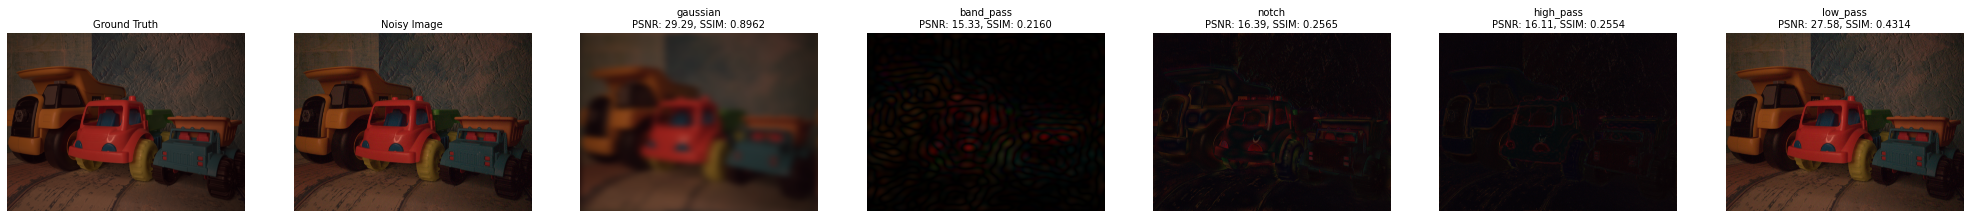

In [25]:
# Load the ground truth and noisy images
gt_image = cv2.imread('SIDD_Small_sRGB_Only/Data/0139_006_IP_00200_00200_3200_L/GT_SRGB_010.PNG')
noisy_image = cv2.imread('SIDD_Small_sRGB_Only/Data/0139_006_IP_00200_00200_3200_L/NOISY_SRGB_010.PNG')

# Apply Fourier transform to the noisy image
dft_noisy = fourier_transform(noisy_image)

filtered_images = []
metrics = []

# List of filter types to apply
filters = ['gaussian', 'band_pass', 'notch', 'high_pass', 'low_pass']

# Initialize dictionaries to store PSNR and SSIM values for each filter type
psnr_values = {}
ssim_values = {}

# Apply different filters to the Fourier-transformed image
for filter_type in filters:
    filtered_dft = apply_filter(dft_noisy, filter_type=filter_type)
    denoised_image = inverse_fourier_transform(filtered_dft)
    denoised_image = np.clip(denoised_image, 0, 255).astype('uint8')
    filtered_images.append(denoised_image)
    psnr, ssim = calculate_metrics(gt_image, denoised_image)
    metrics.append((psnr, ssim))
    psnr_values[filter_type] = psnr
    ssim_values[filter_type] = ssim

# Store and print the PSNR and SSIM values in the specified dictionary format
print("PSNR by filter type:", psnr_values)
print("SSIM by filter type:", ssim_values)

# Display code remains the same
# Determine the size of one subplot and then calculate the total figure size required
subplot_width = 4  # Example width of one subplot
subplot_height = 3  # Example height of one subplot
fig_width = subplot_width * (len(filters) + 2)  # Total figure width
fig_height = subplot_height  # Total figure height as we have only one row

# Prepare to display the images using matplotlib
fig, axs = plt.subplots(1, len(filters) + 2, figsize=(fig_width, fig_height))

# Set the font size for titles to ensure they fit well
title_font_size = 10

# Display the ground truth image
axs[0].imshow(cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Ground Truth', fontsize=title_font_size)
axs[0].axis('off')

# Display the noisy image
axs[1].imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
axs[1].set_title('Noisy Image', fontsize=title_font_size)
axs[1].axis('off')

# Display all filtered (denoised) images and their metrics
for i, (img, metric) in enumerate(zip(filtered_images, metrics), 2):
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].set_title(f'{filters[i-2]}\nPSNR: {metric[0]:.2f}, SSIM: {metric[1]:.4f}', fontsize=title_font_size)
    axs[i].axis('off')

# Adjust layout to prevent overlapping of elements
plt.tight_layout()
# Show the plot with all images
plt.show()


# Error  metric values for our large Test image 1


In [26]:
#below are the average error metric values useful for comparing with state of the art model
print(" PSNR by filter type:", psnr_values)
print(" SSIM by filter type:", ssim_values)

 PSNR by filter type: {'gaussian': 29.291008018025526, 'band_pass': 15.326474687807456, 'notch': 16.39243575658527, 'high_pass': 16.114236270966313, 'low_pass': 27.58012820670787}
 SSIM by filter type: {'gaussian': 0.8961775271453459, 'band_pass': 0.21603292192337872, 'notch': 0.25645748400548574, 'high_pass': 0.255432129550261, 'low_pass': 0.43141340417688107}


## Visualisations of Error metrics of large Test image 1


 PSNR by filter type: {'gaussian': 29.291008018025526, 'band_pass': 15.326474687807456, 'notch': 16.39243575658527, 'high_pass': 16.114236270966313, 'low_pass': 27.58012820670787}
 SSIM by filter type: {'gaussian': 0.8961775271453459, 'band_pass': 0.21603292192337872, 'notch': 0.25645748400548574, 'high_pass': 0.255432129550261, 'low_pass': 0.43141340417688107}


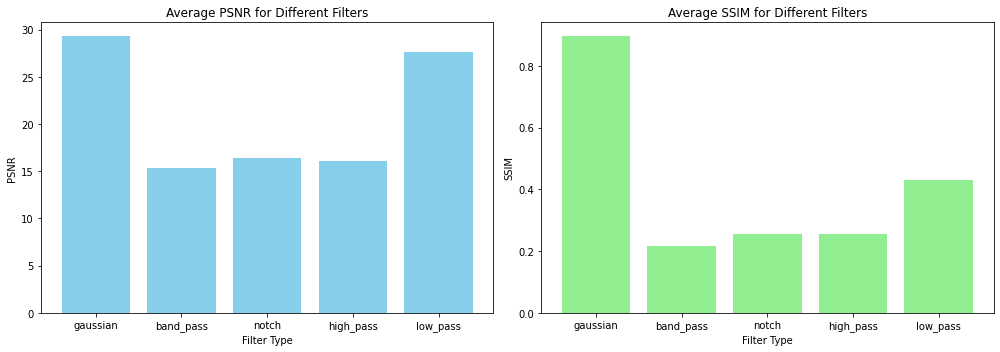

In [27]:
# Error  metric values for our SIDD Dataset
#below are the average error metric values useful for comparing with state of the art model
print(" PSNR by filter type:", psnr_values)
print(" SSIM by filter type:", ssim_values)

# Create bar charts using matplotlib to visualize the average PSNR and SSIM for different filters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart for PSNR
# Here, each bar represents the average PSNR for a specific filter type.
ax1.bar(psnr_values.keys(), psnr_values.values(), color='skyblue')
ax1.set_title('Average PSNR for Different Filters')  # Title for the PSNR subplot
ax1.set_ylabel('PSNR')  # Y-axis label for PSNR values
ax1.set_xlabel('Filter Type')  # X-axis label indicating the filter types

# Bar chart for SSIM
# Similarly, each bar represents the average SSIM for a specific filter type.
ax2.bar(ssim_values.keys(), ssim_values.values(), color='lightgreen')
ax2.set_title('Average SSIM for Different Filters')  # Title for the SSIM subplot
ax2.set_ylabel('SSIM')  # Y-axis label for SSIM values
ax2.set_xlabel('Filter Type')  # X-axis label indicating the filter types

# Adjust layout to prevent overlapping of elements
plt.tight_layout()
# Display the plots
plt.show()


## Testing for one more image which is small size image 2

PSNR by filter type: {'gaussian': 19.362960538999, 'band_pass': 8.159186929754886, 'notch': 8.979385277565518, 'high_pass': 8.514339294064174, 'low_pass': 31.113125127775756}
SSIM by filter type: {'gaussian': 0.5278891780045103, 'band_pass': 0.1410696555784177, 'notch': 0.16517859105063476, 'high_pass': 0.143727619356835, 'low_pass': 0.8657976109010476}


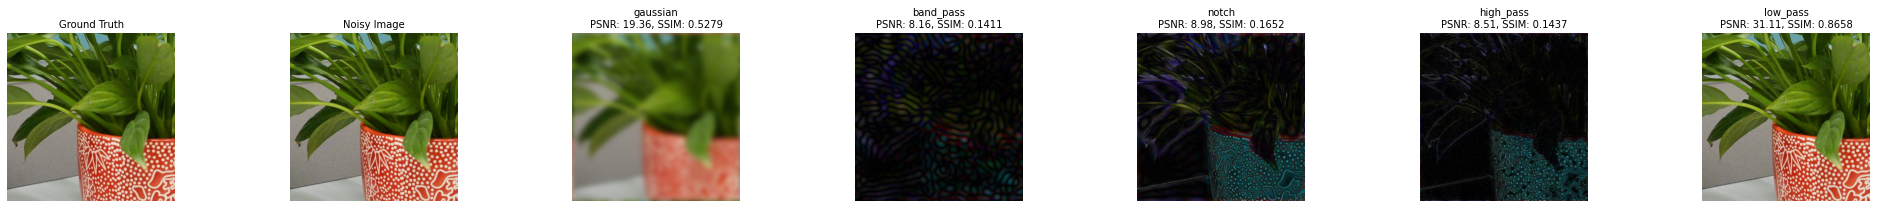

In [28]:
# Load the ground truth and noisy images
gt_image = cv2.imread("Test_Data/Sony_4-5_125_3200_plant_10_mean.JPG")
noisy_image = cv2.imread("Test_Data/Sony_4-5_125_3200_plant_10_real.JPG")

# Apply Fourier transform to the noisy image
dft_noisy = fourier_transform(noisy_image)

filtered_images = []
metrics = []

# List of filter types to apply
filters = ['gaussian', 'band_pass', 'notch', 'high_pass', 'low_pass']

# Initialize dictionaries to store PSNR and SSIM values for each filter type
psnr_values = {}
ssim_values = {}

# Apply different filters to the Fourier-transformed image
for filter_type in filters:
    filtered_dft = apply_filter(dft_noisy, filter_type=filter_type)
    denoised_image = inverse_fourier_transform(filtered_dft)
    denoised_image = np.clip(denoised_image, 0, 255).astype('uint8')
    filtered_images.append(denoised_image)
    psnr, ssim = calculate_metrics(gt_image, denoised_image)
    metrics.append((psnr, ssim))
    psnr_values[filter_type] = psnr
    ssim_values[filter_type] = ssim

# Store and print the PSNR and SSIM values in the specified dictionary format
print("PSNR by filter type:", psnr_values)
print("SSIM by filter type:", ssim_values)

# Display code remains the same
# Determine the size of one subplot and then calculate the total figure size required
subplot_width = 4  # Example width of one subplot
subplot_height = 3  # Example height of one subplot
fig_width = subplot_width * (len(filters) + 2)  # Total figure width
fig_height = subplot_height  # Total figure height as we have only one row

# Prepare to display the images using matplotlib
fig, axs = plt.subplots(1, len(filters) + 2, figsize=(fig_width, fig_height))

# Set the font size for titles to ensure they fit well
title_font_size = 10

# Display the ground truth image
axs[0].imshow(cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Ground Truth', fontsize=title_font_size)
axs[0].axis('off')

# Display the noisy image
axs[1].imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
axs[1].set_title('Noisy Image', fontsize=title_font_size)
axs[1].axis('off')

# Display all filtered (denoised) images and their metrics
for i, (img, metric) in enumerate(zip(filtered_images, metrics), 2):
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].set_title(f'{filters[i-2]}\nPSNR: {metric[0]:.2f}, SSIM: {metric[1]:.4f}', fontsize=title_font_size)
    axs[i].axis('off')

# Adjust layout to prevent overlapping of elements
plt.tight_layout()
# Show the plot with all images
plt.show()


# Error  metric values for our Image 2

In [29]:
#below are the average error metric values useful for comparing with state of the art model
print(" PSNR by filter type:", psnr_values)
print(" SSIM by filter type:", ssim_values)

 PSNR by filter type: {'gaussian': 19.362960538999, 'band_pass': 8.159186929754886, 'notch': 8.979385277565518, 'high_pass': 8.514339294064174, 'low_pass': 31.113125127775756}
 SSIM by filter type: {'gaussian': 0.5278891780045103, 'band_pass': 0.1410696555784177, 'notch': 0.16517859105063476, 'high_pass': 0.143727619356835, 'low_pass': 0.8657976109010476}


## Visualisations of Error metrics of image 2 small size


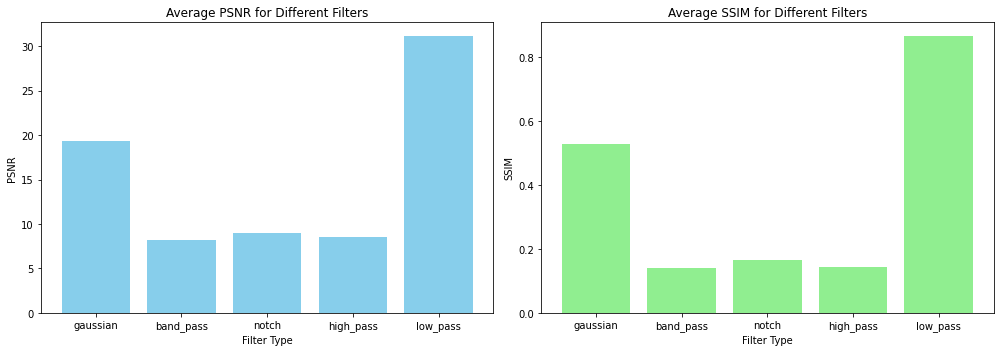

In [30]:
# Create bar charts using matplotlib to visualize the average PSNR and SSIM for different filters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart for PSNR
# Here, each bar represents the average PSNR for a specific filter type.
ax1.bar(psnr_values.keys(), psnr_values.values(), color='skyblue')
ax1.set_title('Average PSNR for Different Filters')  # Title for the PSNR subplot
ax1.set_ylabel('PSNR')  # Y-axis label for PSNR values
ax1.set_xlabel('Filter Type')  # X-axis label indicating the filter types

# Bar chart for SSIM
# Similarly, each bar represents the average SSIM for a specific filter type.
ax2.bar(ssim_values.keys(), ssim_values.values(), color='lightgreen')
ax2.set_title('Average SSIM for Different Filters')  # Title for the SSIM subplot
ax2.set_ylabel('SSIM')  # Y-axis label for SSIM values
ax2.set_xlabel('Filter Type')  # X-axis label indicating the filter types

# Adjust layout to prevent overlapping of elements
plt.tight_layout()
# Display the plots
plt.show()
